In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import datetime

import matplotlib.pyplot as plt

# Assignment 2

This notebook presents the calculations done for the final assignment for the Networks in Social and Economic Systems course. This work is based on papers by PAPER 1 and PAPER 2.

# 0. Relevant functions

In the following code we write the following functions:

* `import_data`: Reads and merges node attributes and edge properties. Returns a DataFrame
* `count_hashtags`: Returns a DataFrame with a column of total hashtags contained in a tweet
* `political_valence`: Calculates the political valence according to the formula: $$V(t) = 2\cdot\frac{N(t, R)/N(R)}{\left[N(t, L)/N(L)\right] + \left[N(t, R)/N(R)\right]} - 1$$

  * where $N(t, R)$ is the number of co-occurrences of hashtag $t$ in tweets by Right-leaning users. $N(t, L)$ is defined in the same way for Left-leaning users
  * $N(R) = \sum_t N(t, R)$ is then the total number of all tags present in tweets by Right-leaning users.

In [2]:
def import_data(node_filename='', edge_filename='', colnames=[], node_only=False, edge_only=False):
    '''
    Returns a pandas DataFrame of the selected network
    ----
    node_filename: str - Name of the node attribute file that contains political leaning of each node
    edge_filename: str - Name of the edge data file that defines the connections in the network
    colnames: list - The data has a variable number of columns in each row. This parameter controls the
              number of columns the DataFrame will have
    '''
    
    if node_only:
        return pd.read_csv(node_filename, sep='\t', header=None, names=['source', 'cluster_id'])
    
    if edge_only:
        edge_df = pd.read_csv(edge_filename, sep='\t', header=None, names=colnames)
    
        edge_df['date'] = pd.to_datetime(edge_df['timestamp'], unit='s')
        edge_df.drop(['timestamp'], axis=1, inplace=True)
        
        return edge_df
    
    node_df = pd.read_csv(node_filename, sep='\t', header=None, names=['source', 'cluster_id'])
    edge_df = pd.read_csv(edge_filename, sep='\t', header=None, names=colnames)
    
    edge_df['date'] = pd.to_datetime(edge_df['timestamp'], unit='s')
    edge_df.drop(['timestamp'], axis=1, inplace=True)
    
    return pd.merge(edge_df, node_df, on='source')

def count_hashtags(df, hashtag_cols):
    '''
    Returns the original DataFrame with a column containing the number of hashtags contained in a tweet
    ----
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    df['total_hashtags'] = df[hashtag_cols].count(axis=1)
    return df

def political_valence(df, hashtag_cols):
    '''
    Applies the formula for the political valence in the ARTICLE 1
    ---
    df: DataFrame - This is the DataFrame generated by the import_data function
    hashtag_cols: list - Each network has a different number of max. hashtags, so the column list must be manually specified
    '''
    # We count ALL the instances of EACH hashtag
    # We reset the index so that we may have a column with the hashtag string
    total_ht = (df[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    
    # Change column names
    colnames = ['hashtag_str'] + hashtag_cols
    total_ht.columns = colnames
    
    # Create a 'totals' column that sums all the instances
    total_ht['totals'] = total_ht[hashtag_cols].sum(axis=1)
    
    # --------------------------------------------------------------------
    # Calculate hashtags of right-leaning users
    
    id_right = df.loc[df['cluster_id']=='right']
    right_ht = (id_right[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    right_ht.columns = colnames # Rename columns after reset_index
    right_ht['sum_r'] = right_ht[hashtag_cols].sum(axis=1)
    # Calculate N_R as a sum of total hashtags
    N_R = right_ht['sum_r'].sum()
    
    # --------------------------------------------------------------------
    # Calculate hashtags of left-leaning users
    id_left = df.loc[df['cluster_id']=='left']
    left_ht = (id_left[hashtag_cols].apply(pd.Series.value_counts)).reset_index()
    left_ht.columns = colnames # Rename columns after reset_index
    left_ht['sum_l'] = left_ht[hashtag_cols].sum(axis=1)
    # Calculate N_L as a sum of total hashtags
    N_L = left_ht['sum_l'].sum()
    
    # --------------------------------------------------------------------
    # We merge the left & right leaning data in two steps:
    temp_df = pd.merge(total_ht, right_ht[['hashtag_str', 'sum_r']], on='hashtag_str')
    total_ht = pd.merge(temp_df, left_ht[['hashtag_str', 'sum_l']], on='hashtag_str')
    
    # --------------------------------------------------------------------
    # We apply the formula for the political valence
    total_ht['pol_valence'] = 2* ( (total_ht['sum_r']/N_R) / ( (total_ht['sum_l']/N_L) + (total_ht['sum_r']/N_R) ) ) - 1
    
    return total_ht

# 1. Retweet Network

The community structure is most clear in the retweet network. Lets do some preliminary data exploration on this network

In [3]:
# Retweet network has max. 9 hashtags
cols = ['source', 'target', 'edge_type', 'num_hyperlinks_in_tweet', 'timestamp', 'hashtag1', 'hashtag2', 'hashtag3', 
        'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define our DataFrame with our import_data function
rt_data = import_data('retweet.nodes', 'retweet.edgelist', cols)

In [4]:
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,date,cluster_id
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-12 16:35:55,right
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-17 03:43:58,right
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-14 08:39:45,right
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-15 03:49:09,right
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-26 10:17:47,right


In [5]:
# With our retweet data (rt_data) we can now calculate the political valence
# We will store the results in a hashtag data (ht_data) dataframe
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']
ht_data = political_valence(rt_data, ht_cols)

In [6]:
ht_data.head()

,hashtag_str,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,totals,sum_r,sum_l,pol_valence
0,#1,54.0,8.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,66.0,30.0,36.0,-0.206492
1,#101010,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794
2,#1013bomb,9.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,15.0,11.0,4.0,0.369166
3,#10210,3.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,4.0,4.0,-0.117794
4,#11,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,-0.117794


In [7]:
ht_data[['hashtag_str', 'pol_valence']]

,hashtag_str,pol_valence
0,#1,-0.206492
1,#101010,-0.117794
2,#1013bomb,0.369166
3,#10210,-0.117794
4,#11,-0.117794
...,...,...
1133,#youth,-0.727343
1134,#youtube,0.355802
1135,#yrnf,0.518878
1136,#yuma,-0.117794


In [187]:
#test = ht_data[['hashtag_str', 'pol_valence']]
#test.columns = ['hashtag1', 'pol_valence']
#print(test.shape)
#test.head()

In [188]:
#test.loc[test['hashtag1']=='#onaflcio']
#test.loc[test['hashtag1']=='#ilgop']

In [189]:
#rt_data.iloc[61154:]['hashtag1'].values

## 1.1 Daily average of political valence

If we calculate the (average?) political valence of each tweet, we can see how left/right political activity evolves over time. First, we need to begin by calculating the average political valence of each tweet
We can track which hashtags are tweeted over time with the timestamp data included in our dataset.

In [8]:
# We define the columns we iterate over
ht_cols = ['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9']

# We define the columns that we will create
ht_vals = ['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9']

# We only store the key-value pair of unique hashtag id's and their political valence
valence_data = ht_data[['hashtag_str', 'pol_valence']]

for i, j in zip(ht_cols, ht_vals):
    valence_data.columns = [i, j]
    rt_data = pd.merge(rt_data, valence_data, on=i, how='left')

In [9]:
# We visualize our results
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,cluster_id,val1,val2,val3,val4,val5,val6,val7,val8,val9
0,12464,7349,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,right,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12464,5776,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,right,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12464,8096,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,right,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12464,7340,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,right,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12464,3648,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,right,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Lets calculate the average valence of each tweet
rt_data['avg_valence'] = rt_data[ht_vals].mean(skipna=True, axis=1)

## 1.2 Valence behaviour according to political leaning

Now lets take a closer look at how the two populations of twitter users score on their political valence. As the paper specifies, each hashtag has a valence score ranging from $[-1, 1]$ according to how left or right the hashtag scores.

In [11]:
# We split the corpus according to their political leaning
data_right = rt_data.loc[rt_data['cluster_id']=='right']
data_left  = rt_data.loc[rt_data['cluster_id']=='left']

In [12]:
# Lets visualize results
#data_right.head()
data_left.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
324,6820,12569,retweet,0,#p2,#progca,#casen,NaN,NaN,NaN,...,-0.67116,NaN,0.377078,NaN,NaN,NaN,NaN,NaN,NaN,-0.147041
325,6820,15242,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
326,6820,14537,retweet,1,#p2,#progca,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
327,6820,15781,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160
328,6820,14415,retweet,1,#p2,#progca,#voteforboxer,NaN,NaN,NaN,...,-0.67116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160


In [13]:
# Lets look at the proportion of left/right tweets
print('Proportion of right-leaning tweets: %.4f'%(data_right.shape[0]/rt_data.shape[0]))
print('Proportion of left-leaning tweets: %.4f'%(data_left.shape[0]/rt_data.shape[0]))

Proportion of right-leaning tweets: 0.5283
Proportion of left-leaning tweets: 0.4717


In [21]:
#data_right['date'].dt.month.value_counts()

### 1.2.1 Valence behaviour over time

It is interesting to look at how political valence evolves as the election draws nearer. Lets create a visualization by sorting the tweet corpus by date

In [14]:
data_left.sort_values(by='date', inplace=True)
data_right.sort_values(by='date', inplace=True)

<ipython-input-14-d96c939dd800>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_left.sort_values(by='date', inplace=True)
<ipython-input-14-d96c939dd800>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right.sort_values(by='date', inplace=True)


In [15]:
# Lets check the order
data_left.date

50638   2010-09-14 04:01:08
10583   2010-09-14 04:06:01
24413   2010-09-14 04:08:11
48321   2010-09-14 04:12:04
39630   2010-09-14 04:12:46
                ...        
45485   2010-11-01 22:34:02
53108   2010-11-01 22:35:51
32398   2010-11-01 22:39:01
59489   2010-11-01 22:40:28
13073   2010-11-01 22:41:25
Name: date, Length: 28849, dtype: datetime64[ns]

### 1.2.2 Graph: political valence over time

There are more than 61000 total tweets in our dataset. Lets see how the valence of each tweet evolves over time

<AxesSubplot:xlabel='date'>

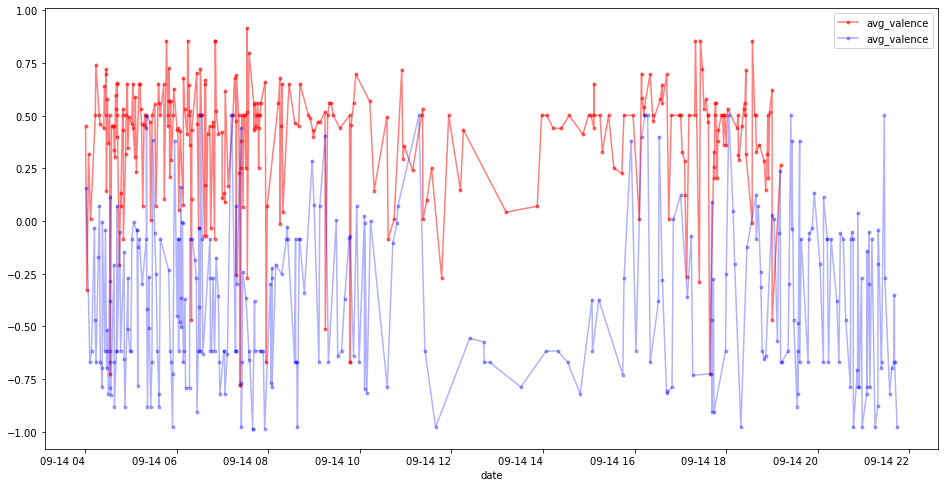

In [16]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

data_right.iloc[0:300].plot(x='date', y='avg_valence', c='r', ax=ax, alpha=0.5, rot=0, marker='.')
data_left.iloc[0:300].plot(x='date', y='avg_valence', c='b', ax=ax, alpha=0.3, rot=0, marker='.')

In [108]:
# TEST
#data_right[['val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'val7', 'val8', 'val9', 'date']].groupby('date').mean()#.reset_index().groupby('date').mean()

### 1.2.3 Daily averages of valence

Unfortunately, the data does not seem to be very interesting. Lets aggregate the average daily valence of the two groups and see if there is any interesting behaviour

In [17]:
# To calculate the saily average, we have to index by date
data_right.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_right = data_right.groupby(pd.Grouper(freq='1D')).mean()


# To calculate the saily average, we have to index by date
data_left.set_index(['date'], inplace=True)
# Group by date and take the mean
daily_mean_val_left = data_left.groupby(pd.Grouper(freq='1D')).mean()

In [18]:
daily_mean_val_left.head()

,source,target,num_hyperlinks_in_tweet,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
date,,,,,,,,,,,,,
2010-09-14,9486.160099,9327.231527,0.628079,-0.493425,-0.323913,-0.303414,-0.199150,-0.165131,-0.275741,-0.435633,-0.564266,NaN,-0.444484
2010-09-15,9894.420601,9464.895565,0.550787,-0.317986,-0.180560,-0.170753,-0.244860,0.008291,-0.301733,-0.210783,-0.482873,-0.031697,-0.277666
2010-09-16,9367.486538,9047.671154,0.634615,-0.427395,-0.249100,-0.279106,-0.288785,-0.032928,-0.244403,-0.176874,-0.401874,0.246481,-0.363774
2010-09-17,7329.519621,9138.603518,0.418133,-0.620701,-0.344133,-0.230534,-0.260814,-0.155748,-0.117509,0.138625,0.057687,0.855717,-0.582701
2010-09-18,9358.782178,9414.745050,0.542079,-0.476301,-0.316405,-0.220832,-0.257060,-0.119599,-0.157022,-0.026687,-0.200700,0.759684,-0.406328


In [197]:
#daily_mean_val_left.shape, daily_mean_val_right.shape

In [19]:
# Calculate mean political valence for left-leaning and right-leaning users
# We will plot this below
mvr = daily_mean_val_right['avg_valence'].mean()
mvl = daily_mean_val_left['avg_valence'].mean()

print('Mean valence of Left-leaning tweets: %.4f'%(mvl))
print('Mean valence of Right-leaning tweets: %.4f'%(mvr))

Mean valence of Left-leaning tweets: -0.3990
Mean valence of Right-leaning tweets: 0.3743


In [20]:
# Lets see if the valence of left and right users are correlated
np.corrcoef(daily_mean_val_right['avg_valence'].values, daily_mean_val_left['avg_valence'].values)

array([[ 1.        , -0.13072553],
       [-0.13072553,  1.        ]])

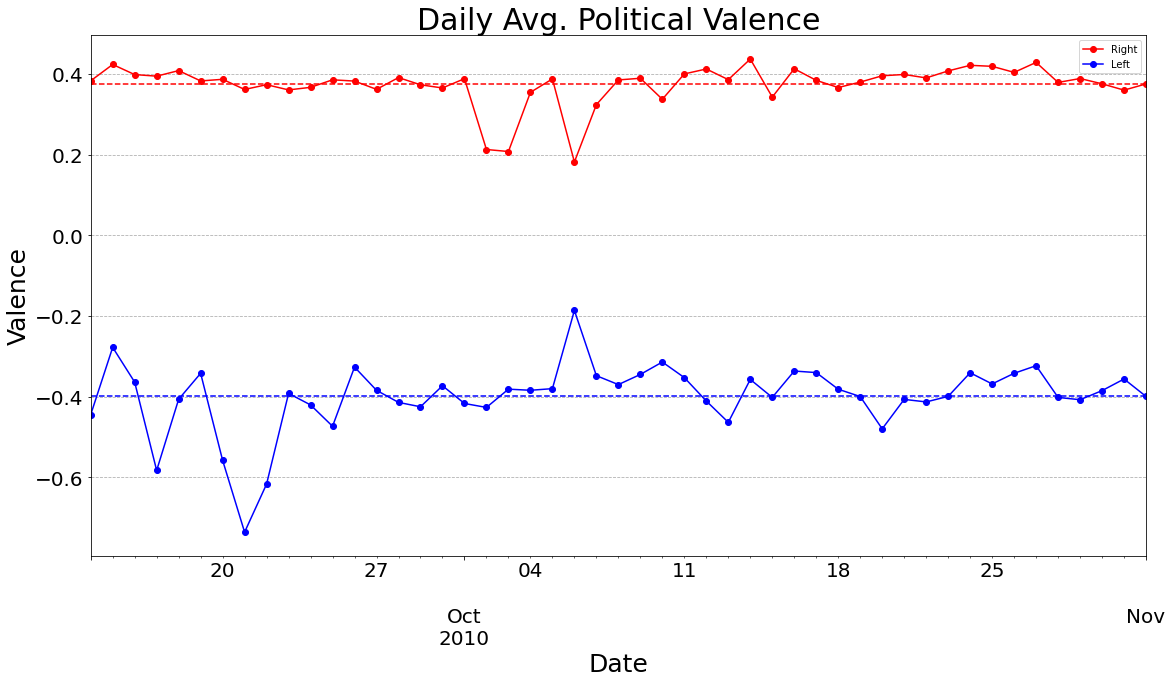

In [21]:
#test = np.log(1 + data_right[ht_vals].mean(axis=1))

# The data spans from 14/09/2010 to 1/11/2010
t0 = datetime.date(2010, 9, 14)
t1 = datetime.date(2010, 11, 1)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

daily_mean_val_right.plot(y='avg_valence', c='r', ax=ax, marker='o', label='Right', fontsize=20)
daily_mean_val_left.plot(y='avg_valence', c='b', ax=ax, marker='o', label='Left')
plt.tight_layout()

ax.set_title('Daily Avg. Political Valence', fontsize=30)
ax.set_ylabel('Valence', fontsize=25)
ax.set_xlabel('Date', fontsize=25)
ax.hlines(mvl, t0, t1, linestyle='--', color='b')#, alpha=0.5)
ax.hlines(mvr, t0, t1, linestyle='--', color='r')#, alpha=0.5)
#ax.vlines(d, -0.65, 0.42, color='black', linestyle='--', alpha=0.5)
ax.grid(linestyle='--', axis='y')

### 1.2.4 Changes in trends

Lets revisit the daily evolution of political valence. By taking a rolling average of NUMBER and BIGGERNUMBER messages, we can see how short-term political messaging changes in comparison to more long-term trends. Even though tweets come from many different sources, we can take these rolling averages as the evolution of the political discourse.

We see that the daily averages are relatively stable. Lets see how the individual tweets correlate with each other

In [22]:
#data_right['diff_val'] = data_right['avg_valence'].diff(periods=1)
#data_left['diff_val'] = data_left['avg_valence'].diff(periods=1)

#data_right['rolling_20'] = data_right['diff_val'].rolling(window=20).mean()
#data_right['rolling_50'] = data_right['diff_val'].rolling(window=50).mean()

#data_left['rolling_20'] = data_left['diff_val'].rolling(window=20).mean()
#data_left['rolling_50'] = data_left['diff_val'].rolling(window=50).mean()

#data_right['diff_val'] = data_right['avg_valence'].diff(periods=1)
#data_left['diff_val'] = data_left['avg_valence'].diff(periods=1)

data_right['rolling_20'] = data_right['avg_valence'].rolling(window=20).mean()
data_right['rolling_50'] = data_right['avg_valence'].rolling(window=50).mean()

data_left['rolling_20'] = data_left['avg_valence'].rolling(window=20).mean()
data_left['rolling_50'] = data_left['avg_valence'].rolling(window=50).mean()

<ipython-input-22-b2056893cfd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right['rolling_20'] = data_right['avg_valence'].rolling(window=20).mean()
<ipython-input-22-b2056893cfd4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_right['rolling_50'] = data_right['avg_valence'].rolling(window=50).mean()
<ipython-input-22-b2056893cfd4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

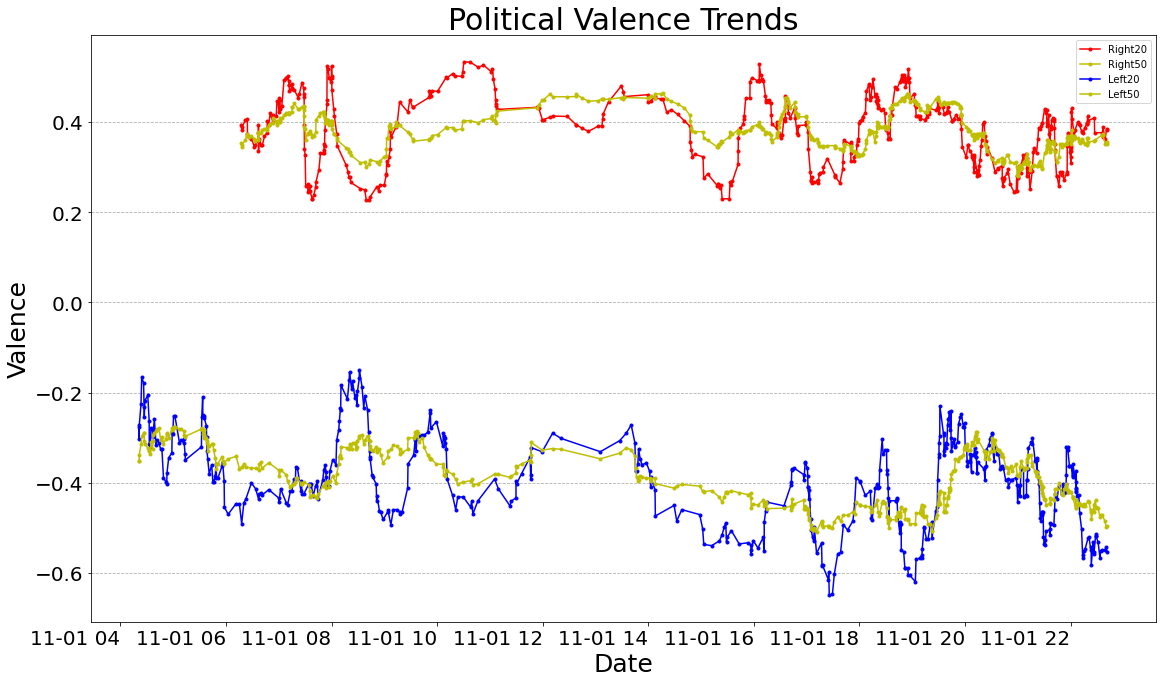

In [23]:
#a, b = 20000, 20300
#a, b = 31808, 32308
b = data_right.shape[0]
a = b - 500

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

data_right.iloc[a:b].plot(y='rolling_20', c='r', ax=ax, marker='.', label='Right20', fontsize=20)
data_right.iloc[a:b].plot(y='rolling_50', c='y', ax=ax, marker='.', label='Right50', fontsize=20)


#a, b = 18310, 18610
#a, b = 28349, 28849
#a, b = 28410, 28849
b = data_left.shape[0]
a = b - 500
data_left.iloc[a:b].plot(y='rolling_20', c='b', ax=ax, marker='.', label='Left20', fontsize=20, rot=0)
data_left.iloc[a:b].plot(y='rolling_50', c='y', ax=ax, marker='.', label='Left50', fontsize=20, rot=0)

#daily_mean_val_left.plot(y='avg_valence', c='b', ax=ax, marker='o', label='Left')
plt.tight_layout()

ax.set_title('Political Valence Trends', fontsize=30)
ax.set_ylabel('Valence', fontsize=25)
ax.set_xlabel('Date', fontsize=25)
#ax.hlines(mvl, t0, t1, linestyle='--', color='b')#, alpha=0.5)
#ax.hlines(mvr, t0, t1, linestyle='--', color='r')#, alpha=0.5)
ax.grid(linestyle='--', axis='y')

In [24]:
#data_left.shape

(28849, 26)

In [25]:
#data_right.shape

(32308, 26)

# 2. Network analysis

Now, lets define our networks. Since we have data with timestamps, we can see how the network structure evolves

In [24]:
rt_data.sort_values(by='date', inplace=True)
#rt_data.set_index(['date'], inplace=True)
rt_data.head()

,source,target,edge_type,num_hyperlinks_in_tweet,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,...,val1,val2,val3,val4,val5,val6,val7,val8,val9,avg_valence
319,12464,1266,retweet,1,#tcot,#tlot,NaN,NaN,NaN,NaN,...,0.501088,0.400243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450665
50638,1864,11180,retweet,0,#ma10,#mapoli,NaN,NaN,NaN,NaN,...,0.186626,0.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154636
45041,10488,7720,retweet,0,#gop,#partyofno,#dems,#democraticsocialistpeoplespartyofnyet,NaN,NaN,...,0.070918,NaN,-0.730342,NaN,NaN,NaN,NaN,NaN,NaN,-0.329712
53830,9408,9682,retweet,0,#tcot,#gop,#teaparty,NaN,NaN,NaN,...,0.501088,0.070918,0.380353,NaN,NaN,NaN,NaN,NaN,NaN,0.317453
10583,12750,12317,retweet,1,#p2,NaN,NaN,NaN,NaN,NaN,...,-0.671160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160


In [25]:
# Lets see what months our data spans
rt_data['date'].dt.month.value_counts() # We see that most of our data is in October, September and November

10    38511
9     21148
11     1498
Name: date, dtype: int64

In [26]:
# We will separate our data into 2 periods: before october and after october
t0 = datetime.date(2010, 10, 1)

sept_data = rt_data.loc[pd.to_datetime(rt_data['date']).dt.date < t0]
oct_data = rt_data.loc[pd.to_datetime(rt_data['date']).dt.date >= t0]

In [27]:
# Lets look at how many tweets are contained in each DataFrame
print('Pre-October data: %i \n(Post-)October data: %i'%(sept_data.shape[0], oct_data.shape[0]))

Pre-October data: 21148 
(Post-)October data: 40009


In [28]:
#edge_attr = ['avg_valence', 'hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 
#             'hashtag8', 'hashtag9']
sept_ntwk = nx.from_pandas_edgelist(df=sept_data, source='source', target='target', edge_attr=['avg_valence'], create_using=nx.DiGraph)
oct_ntwk  = nx.from_pandas_edgelist(df=oct_data,  source='source', target='target', edge_attr=['avg_valence'], create_using=nx.DiGraph)

## 2.1 Node attributes

We begin by incorporating if our nodes are left-leaning or right-leaning.

In [29]:
# Lets make a dictionary with node attributes so that we may signal which nodes are left/right leaning
# We read the data with our function
rt_node_data = import_data(node_filename='retweet.nodes', node_only=True)
# Change the index type -- I dont know if this is necessary
rt_node_data['source'].astype(int)

# We create the node attribute dictionary
node_data_dict = rt_node_data.set_index('source')['cluster_id'].to_dict()

Lets assign the attributes to our nodes

In [30]:
# Assign node attributes
nx.set_node_attributes(sept_ntwk, values=node_data_dict, name='cluster_id')
nx.set_node_attributes(oct_ntwk, values=node_data_dict, name='cluster_id')

### 2.1.1 Connected components

Lets see if the networks are fully connected. It may be interesting to see if opinions are more homogeneous in more niche networks

# I STILL NEED TO FINISH THIS

But it is not that important for now

In [31]:
# Lets check if our networks are fully connected
print('Fully connected September data: ', nx.is_connected(sept_ntwk))
print('Number of connected components:', nx.number_connected_components(sept_ntwk))
print('--------------')
print('Fully connected October data: ', nx.is_connected(oct_ntwk))
print('Number of connected components:', nx.number_connected_components(oct_ntwk))

NetworkXNotImplemented: not implemented for directed type

In [65]:
temp = sept_ntwk.subgraph(max(nx.connected_components(sept_ntwk), key=len)).to_undirected()
#nx.Graph(temp)
#nx.is_strongly_connected()

In [66]:
nx.is_strongly_connected(temp)

NetworkXNotImplemented: not implemented for undirected type

In [32]:
# Lets extract the connected components and sort them by size
sept_sorted = sorted(nx.connected_components(sept_ntwk), key=len, reverse=True)

# September: Total number of nodes
num_nodes = sept_ntwk.number_of_nodes()
percent_nodes = [100*len(i)/num_nodes for i in sept_sorted[0:3]]

print('September' + ': %.3f%%, %.3f%%, %.3f%%'%(percent_nodes[0], percent_nodes[1], percent_nodes[2]))


sept_ntwk.subgraph(max(nx.connected_components(sept_ntwk), key=len))

#print('Is strongly connected:', nx.is_strongly_connected(sept_sorted[0]))

# Lets extract the connected components and sort them by size
oct_sorted = sorted(nx.connected_components(oct_ntwk), key=len, reverse=True)

# September: Total number of nodes
num_nodes = oct_ntwk.number_of_nodes()
percent_nodes = [100*len(i)/num_nodes for i in oct_sorted[0:3]]

print('October' + ': %.3f%%, %.3f%%, %.3f%%'%(percent_nodes[0], percent_nodes[1], percent_nodes[2]))

September: 91.894%, 0.210%, 0.100%
October: 96.403%, 0.081%, 0.081%


# CONTINUE NETWORK ANALYSIS

## 2.2 Network measures

Lets compute some basic network measures for the different dates

### 2.2.1 Degree distribution

In [32]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [33]:
# September in-degree
temp_freq = degree_histogram_directed(sept_ntwk, in_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

sept_in_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
sept_in_deg.index.name = 'Degree'


# September out-degree
temp_freq = degree_histogram_directed(sept_ntwk, out_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

sept_out_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
sept_out_deg.index.name = 'Degree'


# ------------------------ OCTOBER ------------------------

# September in-degree
temp_freq = degree_histogram_directed(oct_ntwk, in_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

oct_in_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
oct_in_deg.index.name = 'Degree'


# September out-degree
temp_freq = degree_histogram_directed(oct_ntwk, out_degree=True)
temp_deg  = [i for i in range(len(temp_freq))]

oct_out_deg = pd.DataFrame({'Frequency': temp_freq}, index=temp_deg)
oct_out_deg.index.name = 'Degree'

Lets visualize the degree distribution for our two networks

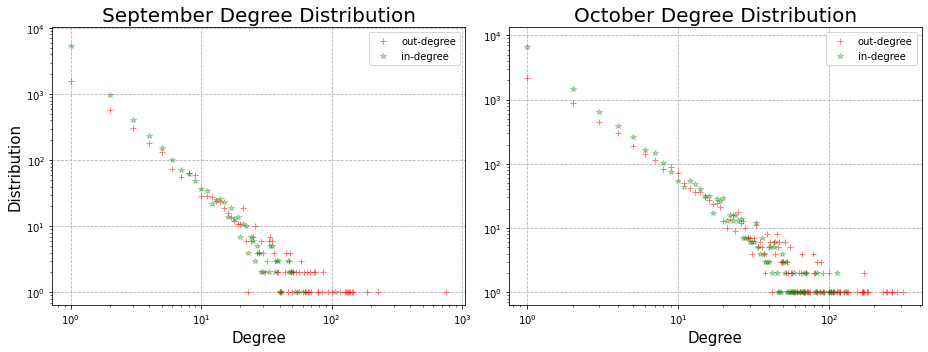

In [34]:
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sept_out_deg.plot(y='Frequency', marker='+', ax=ax1, color='r', label='out-degree', loglog=True, linestyle='none', alpha=0.5)
sept_in_deg.plot(y='Frequency', marker='*', ax=ax1, color='g', label='in-degree', loglog=True, linestyle='none', alpha=0.3)

oct_out_deg.plot(y='Frequency', marker='+', ax=ax2, color='r', label='out-degree', loglog=True, linestyle='none', alpha=0.5)
oct_in_deg.plot(y='Frequency', marker='*', ax=ax2, color='g', label='in-degree', loglog=True, linestyle='none', alpha=0.3)

ax1.set_title('September Degree Distribution', fontsize=20)
ax1.set_xlabel('Degree', fontsize=15)
ax1.set_ylabel('Distribution', fontsize=15)
ax1.grid(linestyle='--')

ax2.set_title('October Degree Distribution', fontsize=20)
ax2.set_xlabel('Degree', fontsize=15)
ax2.grid(linestyle='--')

plt.tight_layout()
plt.show()

### 2.2.2 k-shell Analysis

Lets analyze which nodes belong to the innermost k-shell. These are the nodes with the highest degree which remain after all other nodes of lesser degree are iteratively eliminated

In [35]:
# k-shell nodes
sept_knodes = list(nx.k_shell(sept_ntwk))
oct_knodes  = list(nx.k_shell(oct_ntwk))

# Extract innermost k-shell subgraph
sept_kcore = sept_ntwk.subgraph(sept_knodes)
oct_kcore  = oct_ntwk.subgraph(oct_knodes)

In [36]:
# Lets see how many nodes are inside each k-shell
len(sept_knodes), len(oct_knodes)

(270, 151)

In [93]:
sept_data[['date', 'source', 'target', 'cluster_id', 'edge_type', 'avg_valence']].iloc[0:20]

,date,source,target,cluster_id,edge_type,avg_valence
319,2010-09-14 04:00:21,12464,1266,right,retweet,0.450665
50638,2010-09-14 04:01:08,1864,11180,left,retweet,0.154636
45041,2010-09-14 04:02:04,10488,7720,right,retweet,-0.329712
53830,2010-09-14 04:04:21,9408,9682,right,retweet,0.317453
10583,2010-09-14 04:06:01,12750,12317,left,retweet,-0.671160
27799,2010-09-14 04:06:55,8005,7028,right,retweet,0.007036
24413,2010-09-14 04:08:11,2280,13536,left,retweet,-0.616529
48321,2010-09-14 04:12:04,5377,11805,left,retweet,-0.033051
39630,2010-09-14 04:12:46,6049,10944,left,retweet,-0.470136
19209,2010-09-14 04:13:10,10653,11033,right,retweet,0.501088


# PORTER'S FIVE FORCES

Threat of new entrants, rivalry among competitors, power of suppliers, power of buyers, attractiveness en el trocen

## External factors influencing 

social & demographic changes, 

## Financial ratios

**Cash flow is stable, but there is no clear CF metric**
 * Price/Cash Flow -- an interesting alternative
 
Pros: relatively simple, easy to understand

CONS: Relative, not absolute. What ratio to use? Choose your peer group: what stocks are you comparing? which cmopanies? How are they different? DONT REACH A CONCLUSUION BEFORE SELECTING ANYTHOING. Risk taken into account: scenario analysis: blue skies, cloudy skies? Base scenario, worst & best-case scenario. Is a company laggin with respect to a sector? Why is that company underperforming the sector?

WITH THESE CONSIDERATIONS YOU CAN BUILD YOUR STORY, YOU ARE BUILDING A NARRATIVE WITH THESE FACTORS

## Different types of analysts

Some people work for the buy (often more independent), some for the sale side. Each of them has their own narrative. They have different goals, SEE SLIDES.

# Tom Presentation

"What works on Wall street" James P. O'Shaughnessy

"Do Stocks outperform Treasury Bills?" Hendrik Bessembinder

# BONDS

Capital type: CoCo - 
Issuers
Maturity
etc